In [17]:
import json

import wandb

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12          # Base font size
plt.rcParams['axes.titlesize'] = 18     # Axes title
plt.rcParams['axes.labelsize'] = 12     # X and Y labels
plt.rcParams['xtick.labelsize'] = 13    # X tick labels
plt.rcParams['ytick.labelsize'] = 13    # Y tick labels
plt.rcParams['legend.fontsize'] = 16    # Legend
plt.rcParams['figure.titlesize'] = 22   # Figure title (suptitle)

In [18]:
wandb.login()
api = wandb.Api()

WANDB_PROJECT_ENTITY = "hms-hslu-aicomp-hs25"

# WANDB_PROJECT_NAME = "hms-aicomp-cnn-architectures"
WANDB_PROJECT_NAME = "hms-aicomp-cnn-multispec"

RUN_NAME_FILTER = "alpha_1" # if not None, filter for runs containing this string in their name

In [19]:
runs = api.runs(f"{WANDB_PROJECT_ENTITY}/{WANDB_PROJECT_NAME}")
print(f"Found {len(runs)} runs")

Found 57 runs


In [20]:
runs_data = []
for run in runs:
    run_config = json.loads(run.config)
    run_metrics = json.loads(run.summary_metrics)
    if RUN_NAME_FILTER and RUN_NAME_FILTER not in run.name:
        continue
    run_dict = {
        "id": run.id,
        "name": run.name,
        "fold": run_config["fold"]["value"],
        "architecture": run_config["architecture"]["value"],
        "val_kl_div": run_metrics["best_val_kl_div"],
        "runtime": run_metrics["_runtime"],
    }
    runs_data.append(run_dict)

runs_df = pd.DataFrame(runs_data)
runs_df

,id,name,fold,architecture,val_kl_div,runtime
0,1iqcc0mk,inception_v3-multispec-dropout_0.1-mixup_alpha...,0,inception_v3,0.713638,2474
1,ggctzlki,inception_v3-multispec-dropout_0.1-mixup_alpha...,1,inception_v3,0.620399,2437
2,isqnkqfa,inception_v3-multispec-dropout_0.1-mixup_alpha...,2,inception_v3,0.635174,2453
3,overs1ef,inception_v3-multispec-dropout_0.1-mixup_alpha...,3,inception_v3,0.643763,2524
4,obxt0rhk,inception_v3-multispec-dropout_0.1-mixup_alpha...,4,inception_v3,0.632238,2461


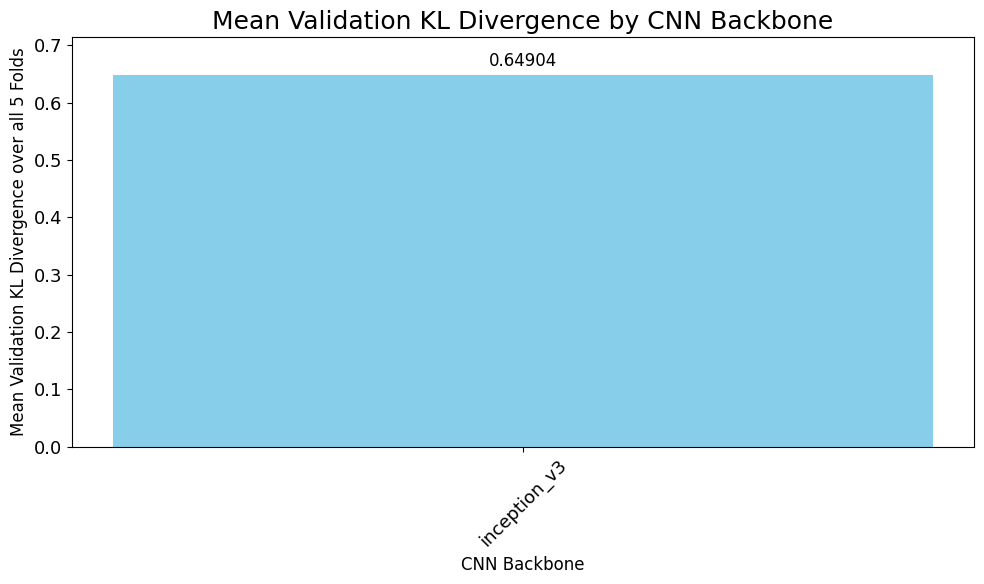

In [21]:
performance_df = runs_df.groupby("architecture")["val_kl_div"].mean().sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(performance_df.index, performance_df.values, color='skyblue')
ax.set_xlabel("CNN Backbone")
ax.set_ylabel("Mean Validation KL Divergence over all 5 Folds")
ax.set_title("Mean Validation KL Divergence by CNN Backbone")
ax.set_ylim(0, performance_df.values.max() * 1.1)
ax.bar_label(bars, fmt='%.5f', padding=3)
plt.xticks(rotation=45)
fig.tight_layout()

fig.savefig("cnn_backbone_performance.svg")

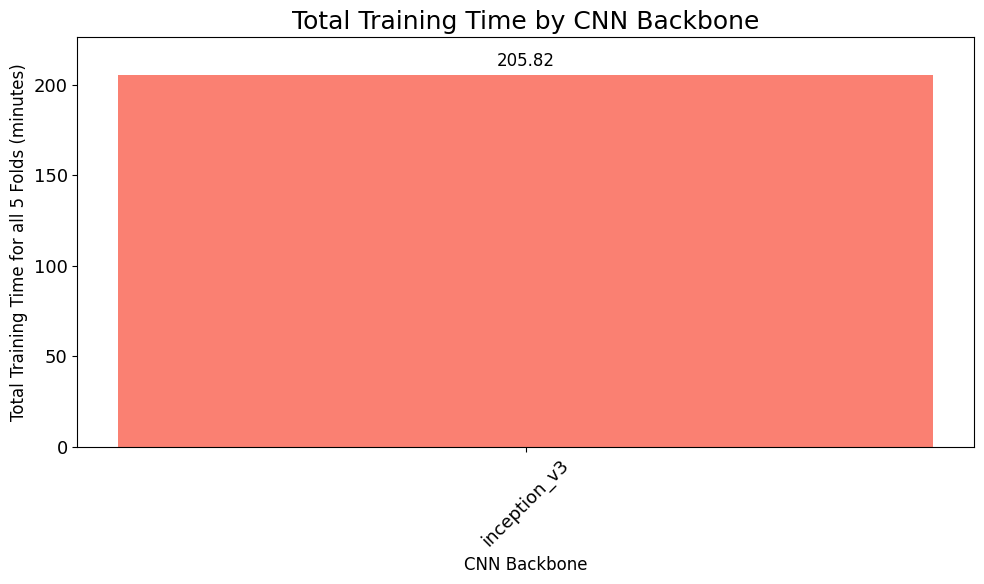

In [22]:
runtime_df = runs_df.groupby("architecture")["runtime"].sum().sort_values()
runtime_df = runtime_df / 60

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(runtime_df.index, runtime_df.values, color='salmon')
ax.set_xlabel("CNN Backbone")
ax.set_ylabel("Total Training Time for all 5 Folds (minutes)")
ax.set_title("Total Training Time by CNN Backbone")
ax.set_ylim(0, runtime_df.values.max() * 1.1)
ax.bar_label(bars, fmt='%.2f', padding=3)
plt.xticks(rotation=45)
fig.tight_layout()

fig.savefig("cnn_backbone_runtime.svg")